# COGS 108 - Final Project 

# Overview

This project explored whether or not there was a relationship between the number of amenities (ex: playground, lake, walkways, etc.) in a park and the park's rating through analyzing data from Yelp park reviews. After extracting and counting amenity keywords from the text reviews, park ratings and park amenity counts were plotted against each other and evaluated. Ultimately, it was found that there is little to no correlation between amount of amenities and park ratings.

# Name & GitHub ID

- Name: Xinyun Sara Yu
- GitHub ID: 59596004

# Research Question

The research question I would like to ask focuses on how to maintain/increase San Diego park popularity; the specific question being: *Is there a relationship between the amount of amenities in a park and the park's public rating?*

## Background and Prior Work

In general, my research question deals with understanding the relationship between park amenities and park popularity. The National Recreation and Park Association (NRPA) asked a similar question (how can neighborhood parks attract more users?) and discussed a study on parks to find out what types of people were using parks, what amenities they used, and what factors led to more park usage (1). It was found that parks were busiest in the afternoons and on weekends, males frequented parks more than females, and adding a new park amenity (ex: tennis courts, playgrounds, etc.) was correlated with a 2 percent increase in the amount of park-goers and physical activity in the park. In addition, amenities such as walking paths and gymnasiums encouraged the most physical activity, however, walking paths existed in less than 30 percent of parks surveyed and gymnasiums in only 9 percent. Lastly, parks with walking loops had 80 percent more users than parks without; every new supervised activity added was associated with a 50 percent increase in park engagement, and marketing efforts correlated with a 62 percent increase in park-goers. NRPA concluded that marketing, investment in park amenities, and adding supervised activities may help increase park popularity.

A report from City Parks Alliance (2) discussed how SOPARC (Systematic Observation of Play and Recreation in Communities), a park measurement tool, helped track user activity, activity types, age, gender, and ethnicity, as well as park accessibility, safety, and usability. Data was collected through direct observation and passive techniques (ex: ground sensors, cellular device detectors in benches). It was found in one study that better walking routes to and from parks could lead to dog owners engaging in more physical activity rather than driving. In another study, it was found that a park having playgrounds, basketball courts, more sidewalks, and safer intersections in the surrounding neighborhoods were all correlated with higher park use in children. Overall, through these findings, there seems to be promise that the quantity of park amenities may be associated with park popularity.

References (include links):

(1) Cohen, D. A., & Leuschner, K. (n.d.). How Can Neighborhood Parks Attract More Users?: Feature: Parks and Recreation Magazine: NRPA. Retrieved from https://www.nrpa.org/parks-recreation-magazine/2017/july/how-can-neighborhood-parks-attract-more-users/

(2) Wagoner, C. V. (2019, March 24). Active Parks, Healthy Cities: Recommendations from the National Study of Neighborhood Parks. Retrieved from https://cityparksalliance.org/resource/active-parks-healthy-cities/ 

# Hypothesis


I hypothesize that the more amenities a park has, the higher the park's rating will be. I imagine parks that offer more amenities will give people more things to do, such as: host birthday parties, play frisbee with friends, have a group picnic, etc. 

# Dataset(s)

- Dataset Name: yelp_SD_parks.csv
- Link to the dataset: Dataset provided by Professor
- Number of observations: 833

The yelp_SD_parks.csv dataset contains the name, address, phone, id, website url, rating, review count, longitude & latitude coordinates, and open/closed status of 833 various parks, beaches, gardens, schools, apartments, farms, museums etc. in San Diego. 

- Dataset Name: yelp_SD_reviews.csv
- Link to the dataset: Dataset provided by Professor
- Number of observations: 2333

The yelp_SD_reviews.csv dataset contains the id (name), rating, and text reviews of various parks, beaches, gardens, schools, etc. in San Diego. There are about 2 to 5 different text reviews for each establishment listed. 

I plan to utilize the name, rating, and review count columns from yelp_SD_parks.csv and the text reviews from yelp_SD_reviews.csv to carry out analysis for this project.

# Setup

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')

import re

import patsy
import statsmodels.api as sm

In [2]:
# reading in data
parks_url = 'https://raw.githubusercontent.com/XinyunSaraYu/individual_fa20/master/data/yelp_SD_parks.csv'
df_parks = pd.read_csv(parks_url)

reviews_url = 'https://raw.githubusercontent.com/XinyunSaraYu/individual_fa20/master/data/yelp_SD_reviews.csv'
df_reviews = pd.read_csv(reviews_url)

# Data Cleaning

### Step 1: Drop Unnecessary Columns

In this section, all the columns that won't be used in this project are removed.

In [3]:
# cleaning df_parks
df_parks = df_parks.drop(columns = ['address','phone', 'id', 'url', 'longitude', 'latitude', 'is_closed'])
df_parks.head()

,name,rating,review_count
0,Balboa Park,5.0,2105
1,Civita Park,4.5,46
2,Waterfront Park,4.5,242
3,Trolley Barn Park,4.5,102
4,Bay View Park,5.0,42


In [4]:
# cleaning df_reviews
df_reviews = df_reviews.drop(columns = ['rating'])
df_reviews.head()

,id,text
0,Balboa Park,Balboa Park is a must see when coming to San D...
1,Balboa Park,Beautiful grounds even to take a stroll during...
2,Balboa Park,Beautiful sightseeing in San Diego. Lots of wa...
3,Civita Park,Was invited to child's B-Day party pre Covid-1...
4,Civita Park,"Pretty nice park, beautiful design. Anyone is..."


### Step 2: Drop Unnecessary/Repeating Rows

Both datasets contain information about various San Diego establishments that are not parks (beaches, nail & spa, schools, etc.), so rows with unnecessary or repeating data are removed here.

In [5]:
# drop all non-park values in the name column of df_parks 
df_parks = df_parks[df_parks['name'].str.contains('Park')]
to_drop = ['Pack & Park', 'Parker', 'North Park', 'Apartments', 'Historic', 'Memorial', 'Theme Parks', 'Inn', 'Golf', 'Zoo', 'Terrace', 'Park Villas', 'Park-it-on-Market', 'Park Diplomat']
df_parks = df_parks[~df_parks['name'].str.contains('|'.join(to_drop))]

# drop all duplicate park names in df_parks
df_parks = df_parks.drop_duplicates(subset = 'name', keep = 'last')
df_parks.count()

name            221
rating          221
review_count    221
dtype: int64

In [6]:
# drop all non-park values in the id column of df_reviews
df_reviews = df_reviews[df_reviews['id'].str.contains('Park')]
to_drop = ['Pack & Park', 'Parker', 'North Park', 'Apartments', 'Historic', 'Memorial', 'Theme Parks', 'Inn', 'Golf', 'Zoo', 'Terrace', 'Park Villas', 'Park-it-on-Market', 'Park Diplomat']
df_reviews = df_reviews[~df_reviews['id'].str.contains('|'.join(to_drop))]

### Step 3: Combine Rows for df_reviews

The dataframe df_reviews has multiple different text review rows for each park, so all text reviews for each park are organized and combined here.

In [7]:
df_reviews['text'] = df_reviews.groupby(['id'])['text'].transform(lambda x : ' '.join(x))
df_reviews = df_reviews.drop_duplicates()
df_reviews.head()

,id,text
0,Balboa Park,Balboa Park is a must see when coming to San D...
3,Civita Park,Was invited to child's B-Day party pre Covid-1...
6,Waterfront Park,"After eating brunch in Little Italy, we decide..."
9,Trolley Barn Park,What a beautiful and welcoming park! I have b...
12,Bay View Park,I LOVE this spot!!! So beautiful at night!! Th...


### Step 4: Count Amenities for Each Park

Amenity keywords are defined in a list and then extracted from the text review column of df_reviews and listed in a new 'amenities' column. Unique amenity keywords are counted and the total count is put inside a new 'amenity_count' column.

In [8]:
# list of amenity keywords to search for within 'text' column of df_reviews
amenities_keywords = ['beautiful', 'view', 'scenic', 'gorgeous', 'playground', 'play structure', 'children\'s area', 'play area', 'lake', 'pond', 'water', 'walkway', 'trail', 'walking path', 'poop bag', 'waste bag', 'pets allowed', 'pet friendly', 'wide', 'large', 'restroom', 'bathroom', 'stage', 'amphitheater', 'lawn', 'nature', 'grass', 'grassy', 'green', 'trees', 'pavilion', 'pavillion', 'gazebo', 'shade', 'shady', 'rec center', 'recreation center', 'basketball', 'b-ball', 'pool', 'bbq', 'safe', 'clean', 'family friendly', 'track', 'field', 'quiet', 'seesaw', 'jungle gym', 'fountain', 'parking', 'bench', 'sand', 'mural', 'tennis', 'baseball', 'soccer', 'sports facility', 'weight room']

# extract all matching keywords into a new 'amenities' column in df_reviews
extract = df_reviews['text'].str.findall('(' + '|'.join(amenities_keywords) + ')', flags = re.IGNORECASE) 
df_reviews['amenities'] = extract.str.join(', ')

In [9]:
# function for grouping similar amenities
def grouping_keywords(string):    
    string = string.lower()

# replacing words related to scenery
    string = string.replace('beautiful', 'nice scenery')
    string = string.replace('view', 'nice scenery')
    string = string.replace('scenic', 'nice scenery')
    string = string.replace('gorgeous', 'nice scenery')
    
# replacing words related to playground
    string = string.replace('play structure', 'playground')
    string = string.replace('children\'s area', 'playground')
    string = string.replace('play area', 'playground')

# replacing words related to pet friendly amenities
    string = string.replace('poop bag', 'pet friendly')
    string = string.replace('waste bag', 'pet friendly')
    string = string.replace('pets allowed', 'pet friendly')

# replacing words related to restroom
    string = string.replace('bathroom', 'restroom')
    
# replacing words related to grass
    string = string.replace('grassy', 'grass')
    string = string.replace('green', 'grass')
    
# replacing words related to shade
    string = string.replace('shady', 'shade')

# replacing words related to rec center
    string = string.replace('recreation center', 'rec center')
    
# replacing words related to basketball
    string = string.replace('b-ball', 'basketball')
    
    return string

In [10]:
# apply function to 'amenities' column
df_reviews['amenities'] = df_reviews['amenities'].apply(grouping_keywords)

# drop 'text' column of df_reviews
df_reviews = df_reviews.drop(columns = ['text'])

In [11]:
# function for splitting strings in 'amenities' column and removing duplicate amenities
def split_count(string):

    if string == '':
        return 0
    
    string_list = string.split(', ')

    string_list = list(dict.fromkeys(string_list))

    return len(string_list)

In [12]:
# apply function to create new 'amenity_count' column
df_reviews['amenity_count'] = df_reviews['amenities'].apply(split_count)

### Step 5: Combine & Finalize Dataframe

Here, the df_parks and df_reviews dataframes are merged into a single dataframe. The dataframe is now ready for analysis.

In [13]:
# combine dataframes
df = pd.merge(left = df_parks, right = df_reviews, left_on = 'name', right_on = 'id')
df = df.drop(columns = {'id', 'review_count'})
df

,name,rating,amenities,amenity_count
0,Balboa Park,5.0,"nice scenery, nice scenery, walkway, nice scen...",2
1,Civita Park,4.5,"family friendly, nice scenery, wide, safe, pla...",5
2,Waterfront Park,4.5,"water, nice scenery, nice scenery, water, clea...",4
3,Trolley Barn Park,4.5,"nice scenery, pet friendly, playground, grass,...",4
4,Bay View Park,5.0,"nice scenery, nice scenery, parking",2
...,...,...,...,...
216,Saratoga Park,5.0,"field, baseball",2
217,Spreckels Park,4.5,"playground, restroom",2
218,Pioneer Park,3.5,"quiet, parking, nature, trees, nice scenery, w...",10
219,Capehart Dog Park,3.0,,0


# Data Analysis & Results

First off, to get a sense of the data, the description table below shows some information about the distributions. Mean park ratings is around 4.05 while mean amount of amenities is about 3.2.

In [14]:
df.describe()

,rating,amenity_count
count,221.000000,221.00000
mean,4.052036,3.20362
std,0.684741,2.32754
min,1.000000,0.00000
25%,3.500000,2.00000
50%,4.000000,3.00000
75%,4.500000,4.00000
max,5.000000,12.00000


### Data Visualization

Below are graphs depicting amenity count distribution and park rating distribution.

Text(0, 0.5, 'Frequency')

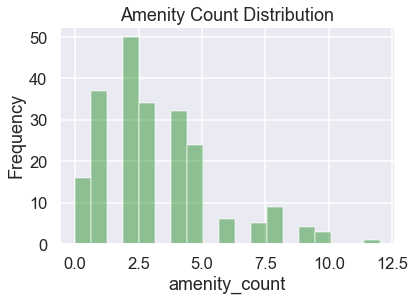

In [15]:
# plot the frequency of amenity counts
amenity_plot = sns.distplot(df['amenity_count'], kde = False, color = 'green')
amenity_plot.set_title('Amenity Count Distribution')
amenity_plot.set_ylabel('Frequency')

Looking at the plot, most amenity counts fall between 0 and 5. 

Text(0, 0.5, 'Frequency')

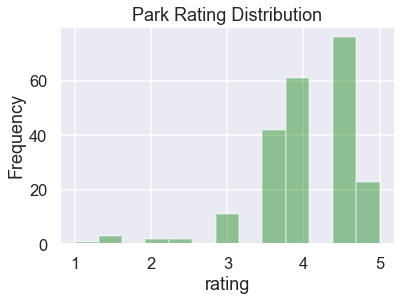

In [16]:
# plot the frequency of park ratings
rating_plot = sns.distplot(df['rating'], kde = False, color = 'green')
rating_plot.set_title('Park Rating Distribution')
rating_plot.set_ylabel('Frequency')

There are very few ratings below 3.5. The majority fall around 4.5.

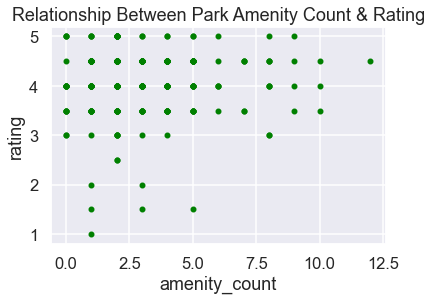

In [17]:
# scatterplot showing relationship between park amenity count and rating
amenity_rating_plot = df.plot.scatter(x = 'amenity_count', y = 'rating', title = 'Relationship Between Park Amenity Count & Rating', color = 'green')

Looking at the scatterplot alone, it is difficult to determine if there is an actual relationship between park amenity count and rating.

### Linear Regression

Here, linear regression is used to analyze the relationship between amenity count and rating through generating the line-of-best-fit.

In [18]:
# making a model
outcome, predictors = patsy.dmatrices('rating ~ amenity_count', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.002
Date:                Thu, 10 Dec 2020   Prob (F-statistic):              0.318
Time:                        00:04:10   Log-Likelihood:                -228.88
No. Observations:                 221   AIC:                             461.8
Df Residuals:                     219   BIC:                             468.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.9884      0.078     50.821

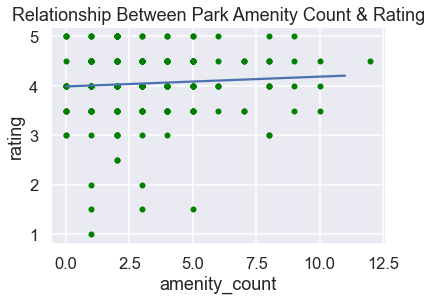

In [19]:
# plot scatter plot with line of best fit
amenity_rating_plot = df.plot.scatter(x = 'amenity_count', y = 'rating', title = 'Relationship Between Park Amenity Count & Rating', color = 'green')

x = np.arange(df['amenity_count'].min(), df['amenity_count'].max())
y = 0.0199 * x + 3.9884
plt.plot(x, y, '-')

Based on the line-of-best-fit, there seems to be a very small positive correlation between amenity count and park rating. 

In [20]:
df.corr()

,rating,amenity_count
rating,1.000000,0.067474
amenity_count,0.067474,1.000000


Specifically, about 6.75% correlation.

# Ethics & Privacy

In terms of ethics and privacy, the data used in this project does not contain personal or sensitive information since it is all public San Diego park/establishments data. In addition, the text reviews do not include the reviewer's username or any identifiable information on the user who submitted the review. Potential biases regarding the data are that all the text reviews were extracted from Yelp, so there are no reviews from people who do not use Yelp or have a Yelp account but did not leave a review. Furthermore, park experiences may differ from person to person, and so even among users who left a review, they may not have mentioned all the amenities of the park they visited, which poses a great bias since the amenity count in this project depends largely on counting keywords mentioned in the text reviews. In addition, the text reviews are shortened versions of their original Yelp entries and the number of text reviews listed for each park in the dataset vary from 2 to 5, all of which may impact amenity count. Lastly, the zip code/location of the parks may influence park popularity and ratings, especially if a certain area of San Diego gets more traffic compared to other more quiet areas and the park happens to be in a busy and convenient place.

To handle these issues, I think collecting text reviews from multiple rating platforms may help lessen the bias slightly. Also, scanning through numerous complete text reviews of each park for amenity keywords may improve the validity of project results. Overall, there are definitely weak areas in this project, however, I hope to continue learning and growing in the field of data science. 

# Conclusion & Discussion

Original Research Question: *Is there a relationship between the amount of amenities in a park and the park's public rating?*

Ultimately, no, in this project it was found there is no relationship between the amount of amenities in a park and the park's rating. My hypothesis that the more amenities a park has the higher the park's rating will be is wrong. Overall, the amenity counts for each park tended to be low while the park ratings were high. When amenity counts and park ratings were plotted together, no visible relationship was shown. After applying the line-of-best-fit to the data, a very small positive correlation was displayed between amenity counts and park ratings, however, it is too small to be of any significance. 

Limitations of this project consist of counting amenities using the Yelp text reviews. The text reviews in the data were only a snippet of their original size, therefore there may have been many additional amenity keywords mentioned that were unable to be counted. In addition, some parks had more reviews listed than others, which tilts the balance of keywords in the data. Though it was an interesting process extracting and counting keywords from the text reviews, there were many factors involved that may have increased the amount of bias in the data.

I think this type of project can be beneficial to society when it comes to city planning and figuring out how to increase park engagement. Many factors come together to create a good park that is popular with locals and tourists alike, and I think asking these types of data science questions is the first step towards learning how to design better parks and improve people's lives in small ways.